<a href="https://colab.research.google.com/github/dishagupta0/roadmap-to-renewable-energy/blob/main/tetouan_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Power Consumption Forecasting for Tetouan City

## Motivation and Business Problem

This notebook aims to serve as a quickstarter guide to demonstrate how Machine Learning (ML) techniques can be applied to real-world problems in the renewable energy sector.

### Context
Tetouan, a city in northern Morocco with a population of approximately 380,000, is undergoing rapid urbanization, leading to increased and variable energy demands. Power utilities and energy planners require data-driven strategies to efficiently manage resources and ensure uninterrupted electricity supply.

Accurate forecasting of power consumption at a granular level enables:
- Efficient energy distribution
- Reduced operational costs
- Improved reliability of power infrastructure
- Better planning for future energy infrastructure investments

The dataset used in this notebook is sourced from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/849/power+consumption+of+tetouan+city), which provides zone-wise power consumption and meteorological data for Tetouan City.

### Objective
We demonstrate how ML & AI can aid in forecasting electricity consumption in order to efficiently adapt to variable energy demands. By anticipating usage patterns, we can strike a balance between meeting growing energy needs and minimizing energy wastage. This involves:
- Analyzing consumption patterns over time
- Identifying key environmental and temporal drivers of electricity use
- Developing predictive models using historical power usage and weather data

By achieving these goals, the notebook aims to showcase how AI can enable smarter grid operations and more sustainable energy planning.


## Data Loading and Initial Setup

In [ ]:
#! pip install -r requirements.txt

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import requests
import zipfile
import io
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set random seed for reproducibility
np.random.seed(42)

# Set better plot aesthetics
plt.style.use('seaborn-whitegrid')
sns.set_palette("viridis")


In [ ]:
# Download and extract CSV from ZIP
url = "https://archive.ics.uci.edu/static/public/849/power+consumption+of+tetouan+city.zip"
response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    with z.open(z.namelist()[0]) as f:
        df = pd.read_csv(f)

# Display the first few rows
print("Dataset initial shape:", df.shape)
df.head()

Dataset initial shape: (52416, 9)


,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


### Data Cleaning and Preprocessing

In [ ]:
# Preview structure
print("\nDataset information before preprocessing:")
df.info()


Dataset information before preprocessing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DateTime                   52416 non-null  object 
 1   Temperature                52416 non-null  float64
 2   Humidity                   52416 non-null  float64
 3   Wind Speed                 52416 non-null  float64
 4   general diffuse flows      52416 non-null  float64
 5   diffuse flows              52416 non-null  float64
 6   Zone 1 Power Consumption   52416 non-null  float64
 7   Zone 2  Power Consumption  52416 non-null  float64
 8   Zone 3  Power Consumption  52416 non-null  float64
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


In [ ]:
# Removes extra spacing from column names for consistency
df.rename(columns={
    'Zone 2  Power Consumption': 'Zone 2 Power Consumption',
    'Zone 3  Power Consumption': 'Zone 3 Power Consumption'
}, inplace=True)

# Convert 'DateTime' column which is currently an 'object' datatype to 'datetime' datatype and set it as index
df['DateTime'] = pd.to_datetime(df['DateTime'], dayfirst=True)
df.set_index('DateTime', inplace=True)

# Preview structure
print("\nDataset information after preprocessing:")
df.info()

# Define key column groups for easier reference
power_cols = ['Zone 1 Power Consumption', 'Zone 2 Power Consumption', 'Zone 3 Power Consumption']
weather_cols = ['Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows', 'diffuse flows']


Dataset information after preprocessing:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52416 entries, 2017-01-01 00:00:00 to 2017-12-30 23:50:00
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Temperature               52416 non-null  float64
 1   Humidity                  52416 non-null  float64
 2   Wind Speed                52416 non-null  float64
 3   general diffuse flows     52416 non-null  float64
 4   diffuse flows             52416 non-null  float64
 5   Zone 1 Power Consumption  52416 non-null  float64
 6   Zone 2 Power Consumption  52416 non-null  float64
 7   Zone 3 Power Consumption  52416 non-null  float64
dtypes: float64(8)
memory usage: 3.6 MB


In [ ]:
print("\nSample data:")
df.head()


Sample data:


,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
DateTime,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


## Exploratory Data Analysis (EDA)
### Initial Exploration and Data Coverage

In [ ]:
# Check time coverage and frequency
print("\nDate range:", df.index.min(), "to", df.index.max())
time_diff = (df.index[1] - df.index[0]).seconds / 60
print("Sampling frequency:", time_diff, "minutes")
print("Number of observations:", len(df))
print("Expected observations for complete year at 10-min intervals:", 365*24*6)

# Summary statistics
print("\nSummary statistics:")
df.describe().T


Date range: 2017-01-01 00:00:00 to 2017-12-30 23:50:00
Sampling frequency: 10.0 minutes
Number of observations: 52416
Expected observations for complete year at 10-min intervals: 52560

Summary statistics:


,count,mean,std,min,25%,50%,75%,max
Temperature,52416.0,18.810024,5.815476,3.247000,14.410000,18.780000,22.890000,40.01000
Humidity,52416.0,68.259518,15.551177,11.340000,58.310000,69.860000,81.400000,94.80000
Wind Speed,52416.0,1.959489,2.348862,0.050000,0.078000,0.086000,4.915000,6.48300
general diffuse flows,52416.0,182.696614,264.400960,0.004000,0.062000,5.035500,319.600000,1163.00000
diffuse flows,52416.0,75.028022,124.210949,0.011000,0.122000,4.456000,101.000000,936.00000
Zone 1 Power Consumption,52416.0,32344.970564,7130.562564,13895.696200,26310.668692,32265.920340,37309.018185,52204.39512
Zone 2 Power Consumption,52416.0,21042.509082,5201.465892,8560.081466,16980.766032,20823.168405,24713.717520,37408.86076
Zone 3 Power Consumption,52416.0,17835.406218,6622.165099,5935.174070,13129.326630,16415.117470,21624.100420,47598.32636


> **Note:**  
> The initial calculation (`365 × 24 × 6 = 52,560`) suggested that 144 observations were missing (`52,560 - 52,416 = 144`). It's important to verify such discrepancies to rule out systematic issues — for example, if a sensor had defaulted for an extended period, it could introduce bias into the model.  
>  
> In our case, a closer inspection reveals that the data spans only 364 days (from January 1 to December 30, 2017), not the full 365. Therefore, the 144 "missing" records are simply due to one less day of data collection, and not a data quality issue.


### Distribution of Features

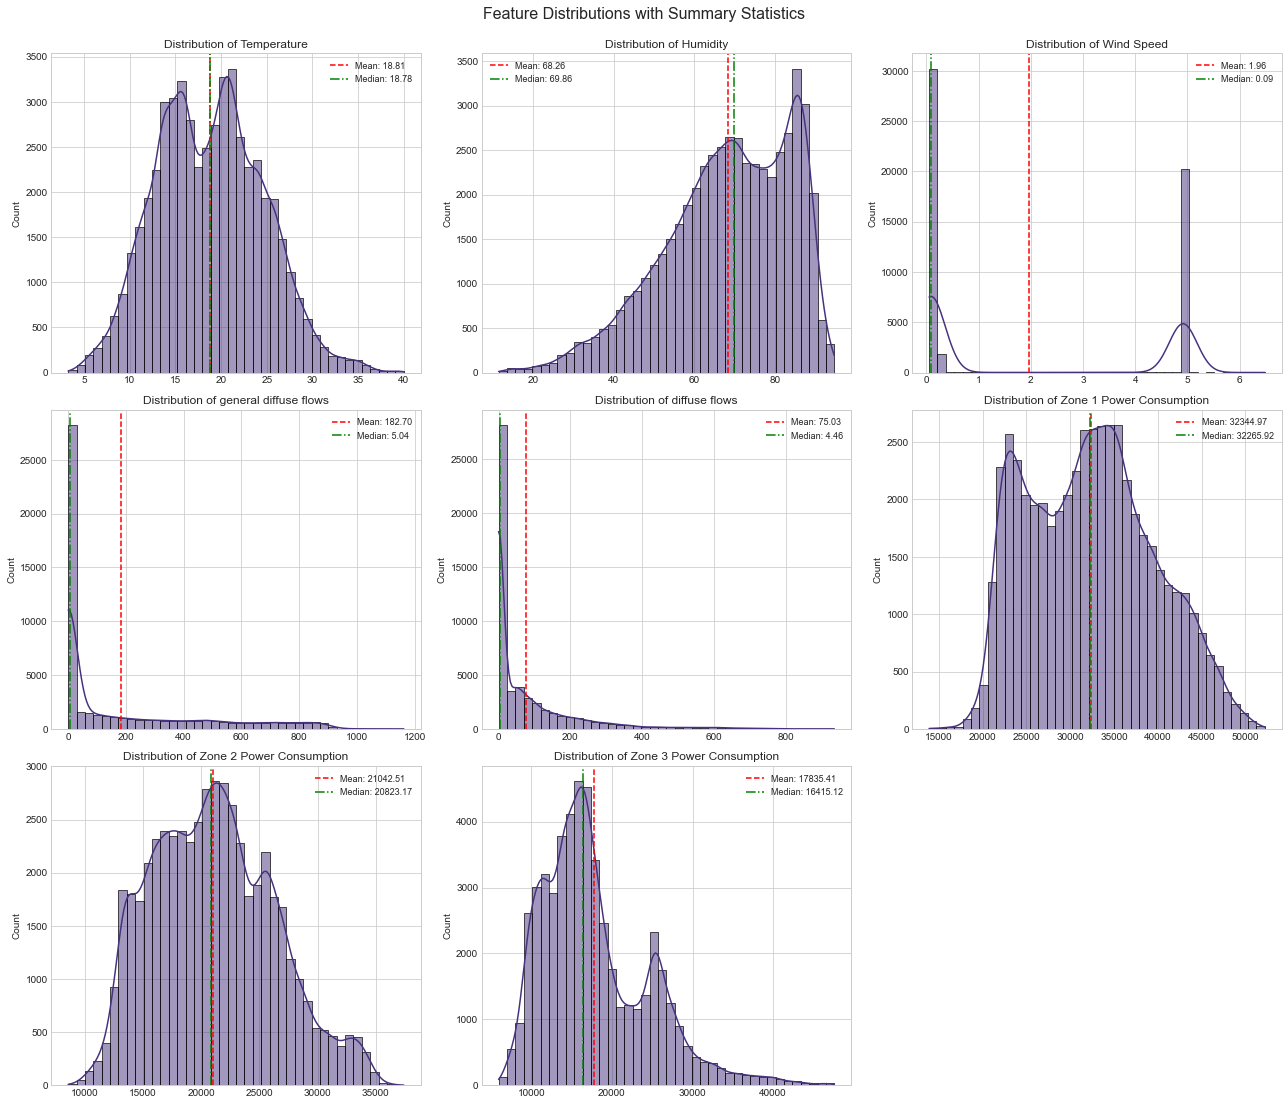

In [ ]:
# Plot histogram and KDE for numeric columns
num_cols = df.select_dtypes(include=np.number).columns
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    if i < len(axes):
        sns.histplot(df[col].dropna(), kde=True, bins=40, ax=axes[i])
        axes[i].set_title(f"Distribution of {col}", fontsize=12)
        axes[i].set_xlabel("")
        mean_val = df[col].mean()
        median_val = df[col].median()
        axes[i].axvline(mean_val, color='r', linestyle='--', label=f'Mean: {mean_val:.2f}')
        axes[i].axvline(median_val, color='g', linestyle='-.', label=f'Median: {median_val:.2f}')
        axes[i].legend(fontsize=9)

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.suptitle("Feature Distributions with Summary Statistics", y=1.02, fontsize=16)
plt.show()

**Outlier Detection and Its Importance in Energy Forecasting**

- Outlier detection is a critical step in any machine learning pipeline, especially when working with real-world sensor or operational data like power consumption. Outliers can:
 - Skew the distribution of data, affecting statistical summaries like mean and variance.
 - Mislead model training by introducing noise or bias.
 - Indicate genuine anomalies such as equipment malfunctions, spikes in demand, or sensor errors all of which may require further investigation or treatment.


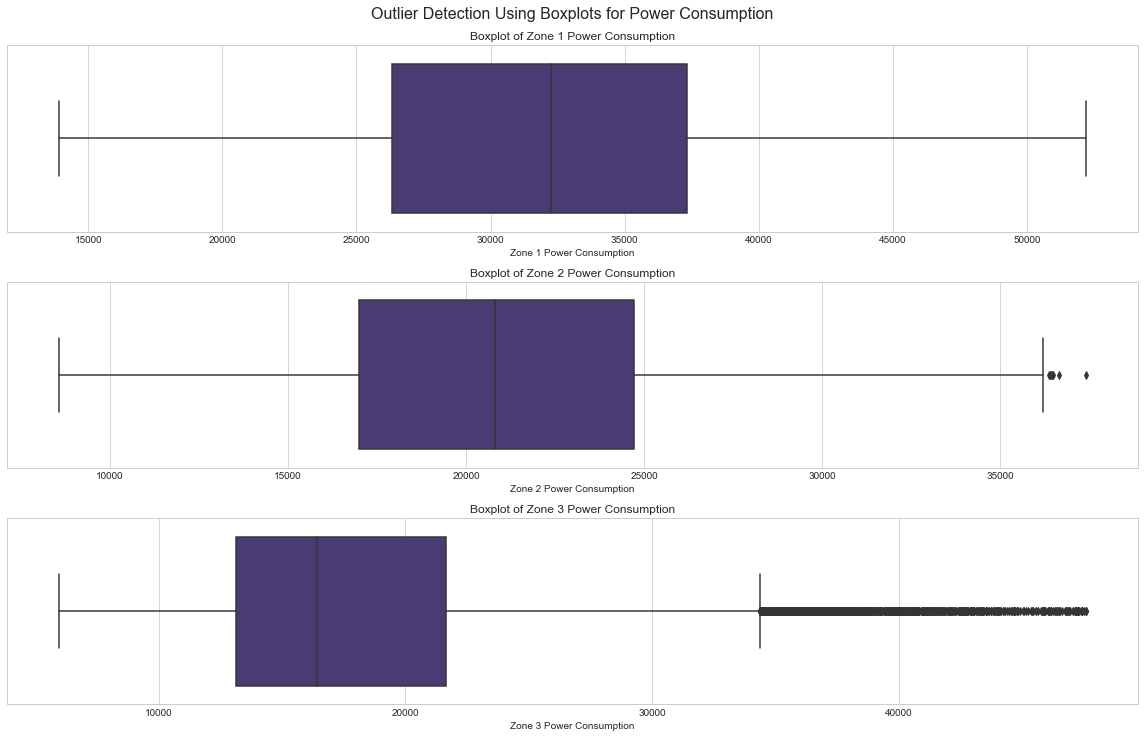

In [ ]:
# Create boxplots to identify outliers
plt.figure(figsize=(16, 10))
for i, col in enumerate(power_cols):
    plt.subplot(3, 1, i+1)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}", fontsize=12)
    plt.tight_layout()
plt.suptitle("Outlier Detection Using Boxplots for Power Consumption", y=1.02, fontsize=16)
plt.show()

In the above boxplots:
- **Zone 3** displays a **significant number of high-end outliers**, suggesting frequent power consumption surges/irregular demand patterns, or possible data logging issues.
- **Zones 1 and 2** have relatively stable distributions with minimal extreme values.

These observations influence how we treat the data prior to modeling — for example, applying outlier clipping, transformation, or using robust models less sensitive to extreme values. In our case, they also highlight the potential need for zone-specific modeling strategies due to differing data characteristics.

### Correlation Analysis

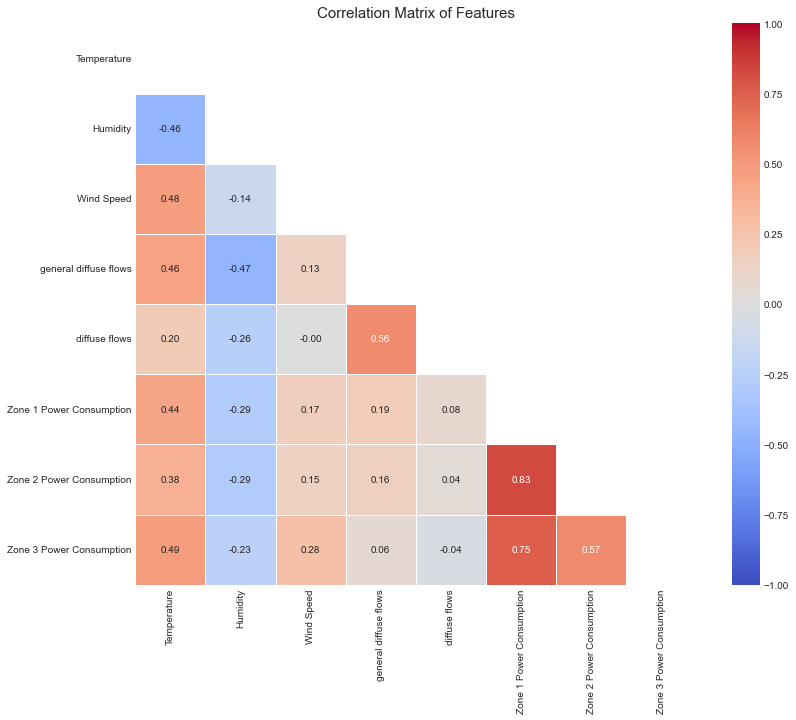

In [ ]:
# Compute correlation matrix
corr_matrix = df.corr()

# Create heatmap of correlations
plt.figure(figsize=(12, 10))
mask = np.triu(corr_matrix)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=mask,
            vmin=-1, vmax=1, center=0, square=True, linewidths=.5)
plt.title("Correlation Matrix of Features", fontsize=15)
plt.tight_layout()
plt.show()

### Correlation Matrix Analysis

Generating a correlation matrix is a common practice that provides valuable insights into how different features correlate with one another and with the target variables (zone-wise power consumption). Key takeaways from the above heatmap:

- **Strong inter-zone correlations**: Zone 1 and Zone 2 power consumption have a very high positive correlation (**0.83**), indicating similar usage patterns or shared influencing factors like grid structure or geographic proximity.

- **Temperature** shows positive correlation with all three zones (e.g., **0.44** with Zone 1), suggesting that electricity demand rises with warmer weather.

- **Humidity** has a mild negative correlation with power consumption (e.g., **-0.29** with Zones 1 and 2), possibly because humid days coincide with cooler temperatures in Tetouan. The strong negative correlation between **humidity and temperature (-0.46)** further supports this.

- **Diffuse solar radiation flows** (both general and specific) show weak or inconsistent correlations with power consumption. This implies they don’t have an obvious linear relationship with electricity usage and may not be useful for **simple linear regression-style models**. However, more complex models (e.g., tree-based or neural networks) could still capture any nonlinear patterns they might contain.

These relationships can inform feature selection, highlight potential redundancy (e.g., between zones), and point to causal patterns worth investigating further with domain knowledge.


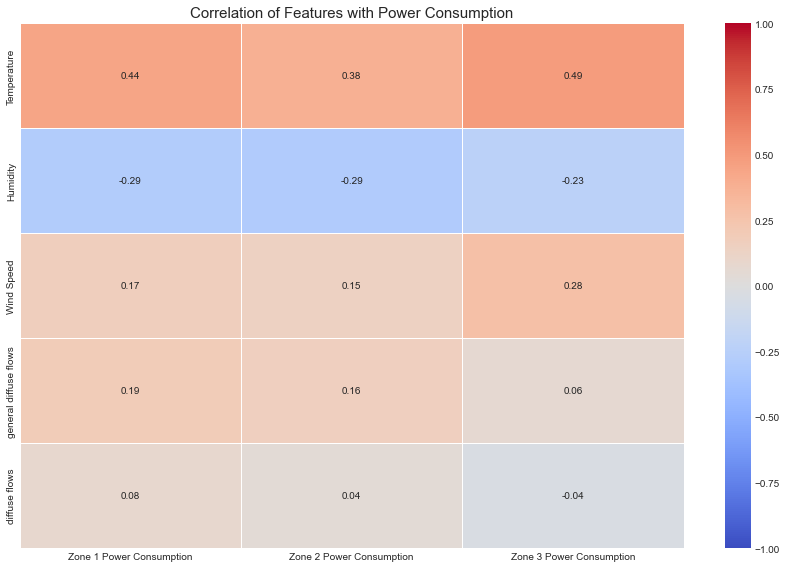

In [ ]:
# Focusing on correlations with the target variable (Power consumption)
power_corr = corr_matrix[power_cols].drop(power_cols)
plt.figure(figsize=(12, 8))
sns.heatmap(power_corr, annot=True, fmt=".2f", cmap="coolwarm",
            vmin=-1, vmax=1, center=0, linewidths=.5)
plt.title("Correlation of Features with Power Consumption", fontsize=15)
plt.tight_layout()
plt.show()

## Model Training and Evaluation

In [ ]:
features = ['Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows',
       'diffuse flows']
target = 'Zone 1 Power Consumption'

### Model Evaluation: Metrics and Validation Strategy

To assess how well our models learn from data and generalize to unseen scenarios, we split our dataset into **training** and **testing** sets. The training set is used to fit the model, while the test set helps us evaluate how well the model performs on new, unseen data.

### Why Compare Train vs. Test Performance?
- **Training error** shows how well the model fits the known data.
- **Testing error** reveals how well the model actually performed in an unseen scenario/production.
- A large gap between the two often indicates **overfitting** (i.e model memorizes training data but fails on new data).

### Key Evaluation Metrics:
- **R² Score (Coefficient of Determination)**: Measures how well the model explains the variance in the target variable. Ranges from 0 to 1 (higher is better).
- **RMSE (Root Mean Squared Error)**: Penalizes larger errors more heavily. Useful for understanding prediction error in the same units as the target.
- **MAE (Mean Absolute Error)**: The average absolute difference between predicted and actual values. More robust to outliers than RMSE.
- **MAPE (Mean Absolute Percentage Error)**: Expresses error as a percentage of actual values — useful for interpretability but can be sensitive to near-zero values.

By comparing these metrics across models, we can choose the best-performing one and identify whether further tuning or feature engineering is needed.


In [ ]:
# Helper function to evaluate models
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    metrics = {
        'Model': name,
        'Train R2': r2_score(y_train, y_pred_train),
        'Test R2': r2_score(y_test, y_pred_test),
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'Train MAE': mean_absolute_error(y_train, y_pred_train),
        'Test MAE': mean_absolute_error(y_test, y_pred_test),
        'Test MAPE': np.mean(np.abs((y_test - y_pred_test) / (y_test + 1e-5))) * 100
    }
    return metrics

# Define models to compare
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.01),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Prepare data
X = df[features]
y = df[target]
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]


In [ ]:
# Evaluate each model
results = []
for name, model in models.items():
    metrics = evaluate_model(name, model, X_train, y_train, X_test, y_test)
    results.append(metrics)

results_df = pd.DataFrame(results)
results_df.set_index("Model", inplace=True)
results_df.sort_values("Test R2", ascending=False, inplace=True)

# Show results
display(results_df)

,Train R2,Test R2,Train RMSE,Test RMSE,Train MAE,Test MAE,Test MAPE
Model,,,,,,,
Gradient Boosting,0.362081,0.048759,5729.333537,6014.169853,4507.037797,4774.936183,17.942949
Lasso Regression,0.192089,0.044084,6447.676267,6028.931950,5314.320299,5082.744315,18.928821
Ridge Regression,0.192089,0.044084,6447.676267,6028.932342,5314.320325,5082.744596,18.928823
Linear Regression,0.192089,0.044084,6447.676267,6028.932599,5314.320342,5082.744456,18.928821
Random Forest,0.947564,-0.223839,1642.615408,6821.700465,1089.681304,5008.637028,18.873822


In [ ]:
results_df.to_csv('basic_nb_eval_results.csv')

## Conclusion

The results above provide a comparative view of how different models perform on the energy consumption forecasting task:

- **Gradient Boosting** delivers the best overall performance, achieving the highest test R² (0.0488) and the lowest test RMSE (~6014). While the R² values are modest, this model demonstrates some ability to generalize beyond the training data.

- **MAPE** values for all models are in the range of 17–19%, with Gradient Boosting achieving the lowest at approximately 17.94%, reinforcing its relative advantage.

- **Linear Regression**, **Ridge**, and **Lasso Regression** show nearly identical results, indicating that the current feature set does not strongly support linear relationships. Their low test R² scores (~0.044) suggest that the raw features are insufficient for accurate prediction with simple linear models.

- **Random Forest** shows clear signs of **overfitting**: it has an extremely high training R² (**0.95**) but a negative test R² (**-0.22**), which means it fails to generalize and performs even worse than predicting the mean. This highlights that using a more complex or powerful machine learning model **does not inherently lead to better performance** — especially when the underlying data lacks informative features or is not well-processed.

These findings underscore the need for stronger feature engineering and domain knowledge-informed transformations to improve predictive performance — a key focus of the advanced notebook that follows.
